In [71]:
import tensorflow as tf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import random
import gzip
import pickle

## Load Voxel-Data

Voxel shape: (16, 16, 16)


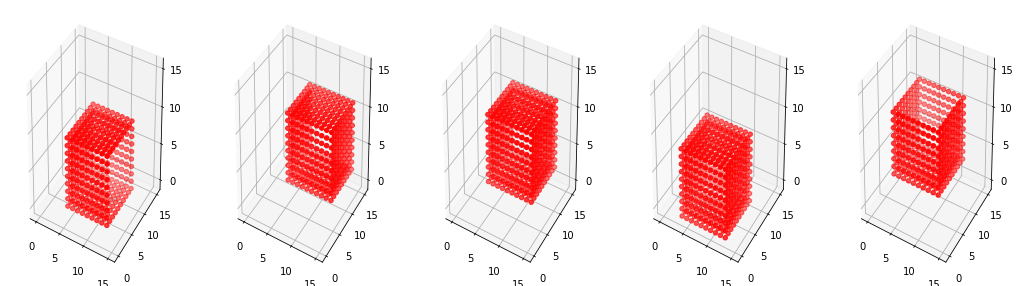

In [79]:
file = './voxel_shapes_len343_ss16_cs10_q0_shift3px.pgz'
data = None
with gzip.open(file, 'r') as f:
    data = pickle.load(f)
#for k in data.keys():
#    print(k, type(data[k]))

random.shuffle(data['voxelShapes'])

# show some samples
fig = plt.figure(figsize=(18, 5))
print('Voxel shape:', np.shape(data['voxelShapes'][0]))
for n in range(5):
    ax = plt.subplot(1, 5, n+1, projection='3d')
    ax.set_xlim(-1,16)
    ax.set_ylim(-1,16)
    ax.set_zlim(-1,16)
    #ax = fig.add_subplot(111, projection='3d')
    x = []
    y = []
    z = []
    for i in range(15):
        for j in range(15):
            for k in range(15):
                if data['voxelShapes'][n][i][j][k] == 1:
                    x.append(i)
                    y.append(j)
                    z.append(k)
    
    ax.scatter(x,y,z,c='red')


## Hyperparameters

In [7]:
BETA = 42
Z_SIZE = 48
BATCH_SIZE = 128
EPOCHS = 50
E = 1e-10

## beta-VAE-Network

In [8]:
def conv(inputs, filters, kernel_size, strides, activation=tf.nn.relu):
    return tf.layers.conv2d(inputs, filters, kernel_size, strides=(strides, strides),
                        padding='SAME', activation=activation)

def deconv(inputs, filters, kernel_size, strides, activation=tf.nn.relu):
    return tf.layers.conv2d_transpose(inputs, filters, kernel_size, strides=(strides, strides),
                        padding='SAME', activation=activation)

def sample(mean, std):
    with tf.variable_scope('random_sampling'):
        shape = tf.shape(mean)
        random_sample = tf.random_normal(shape)
        return mean + tf.exp(std * .5) * random_sample
    #noise = np.random.normal(loc=mean, scale=std, size=len(mean)) # * std + mean

In [ ]:
tf.reset_default_graph()

# define variational autoencoder
with tf.variable_scope('Image-Input'):
    img_input = tf.placeholder(tf.float32, [None, 28, 28, 1])

with tf.variable_scope('Encoder', reuse=tf.AUTO_REUSE):
    encoding = conv(img_input, 32, 3, 2)
    encoding = conv(encoding, 64, 3, 2)
    encoding = conv(encoding, 128, 3, 1)
    flatten = tf.layers.flatten(encoding)
    
    #z = tf.layers.dense(flatten, Z_SIZE, activation=tf.nn.relu)
    z_mean = tf.layers.dense(flatten, Z_SIZE)
    z_std = tf.layers.dense(flatten, Z_SIZE)

with tf.variable_scope('Sample-Encoding'):
    z = sample(z_mean, z_std) 
    z_input = tf.placeholder_with_default(z, [None, Z_SIZE])
    #tf.cond(training, true_fn=sample(z_mean, z_std), false_fn=z_mean)
    #z_input = tf.placeholder(tf.float32, [None, Z_SIZE, 1])

with tf.variable_scope('Decoder', reuse=tf.AUTO_REUSE):
    decoding = tf.layers.dense(z_input, 7*7*128, activation=tf.nn.relu)
    decoding = tf.reshape(decoding, [-1, 7, 7, 128]) 
    decoding = deconv(decoding, 128, 3, 1)
    decoding = deconv(decoding, 64, 3, 2)
    decoding = deconv(decoding, 32, 3, 2)
    decoding = deconv(decoding, 1, 3, 1, activation=tf.nn.sigmoid) 
    
with tf.variable_scope('Loss', reuse=tf.AUTO_REUSE):
    #reconstruction_loss = tf.losses.mean_pairwise_squared_error(img_input, decoding)
    reconstruction_loss = tf.norm(img_input - decoding, ord='euclidean')
    #kl_divergence = 0.5 * tf.reduce_sum(tf.square(z_std) + tf.square(z_mean) \
    #                                    - tf.log(E + tf.square(z_std)) - 1, axis=1)
    kl_divergence = -0.5 * tf.reduce_sum(1.0 + 2.0 * z_std - tf.square(z_mean) - tf.exp(2.0 * z_std), 1)
    loss = tf.reduce_mean(reconstruction_loss + 0.5 * BETA * kl_divergence)
with tf.variable_scope('Train', reuse=tf.AUTO_REUSE):
    train = tf.train.AdamOptimizer(0.0001).minimize(loss)

## Tensorboard

In [23]:
tf.summary.scalar('reconstruction_loss/convolutional', tf.reduce_mean(reconstruction_loss))
tf.summary.scalar('kl_divergence/convolutional', tf.reduce_mean(kl_divergence))
tf.summary.scalar('loss/convolutional', tf.reduce_mean(loss))
tf.summary.scalar('z-mean/convolutional', tf.reduce_mean(z_mean))
tf.summary.scalar('z-std/convolutional', tf.reduce_mean(z_std))
tf.summary.histogram('encoding/convolutional', z_input)
tf.summary.image('Source-Image/convolutional', img_input)
tf.summary.image('Reconstructed-Image/convolutional', decoding)
summary = tf.summary.merge_all()

## Training Loop

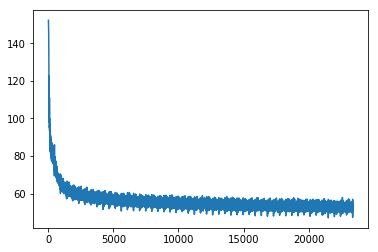

In [24]:
iterations_per_epoch = len(X_train) // BATCH_SIZE
losses = []

sess = tf.Session()

summary_writer = tf.summary.FileWriter('tensorboard', sess.graph)
sess.run(tf.global_variables_initializer())

for e in range(EPOCHS):
    for i in range(iterations_per_epoch):
        batch = X_train[i*BATCH_SIZE : (i+1) * BATCH_SIZE]
        batch = np.expand_dims(batch, 3)
        l, _ = sess.run([loss, train], feed_dict={ img_input : batch })
        losses.append(l)
        if i % 10 == 0:
            s = sess.run(summary, feed_dict={ img_input : batch })
            summary_writer.add_summary(s, e*iterations_per_epoch+i)
    if (e+1) % 10 == 0:
        print('Finished training epoch', e+1, 'with mean loss', np.mean(losses[-iterations_per_epoch:]))


plt.plot(losses)

## Test on unseen data

/media/luca/a87b7b03-b48e-49f3-903a-66c8d0de2388/python_projects/virt_envs/tf_venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  after removing the cwd from sys.path.


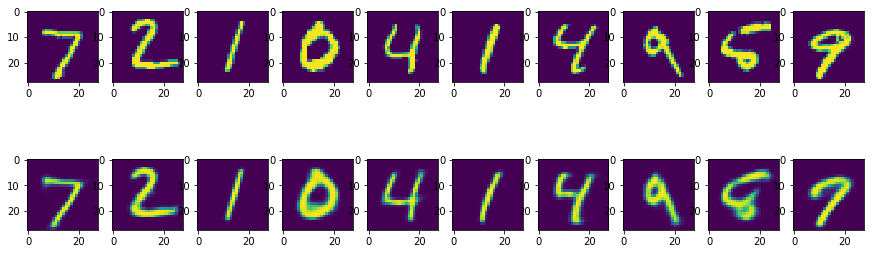

In [25]:
plt.figure(figsize=(15, 5))
for i in range(10):
    img = X_test[i]
    img_in = [np.expand_dims(img, 3)]
    reconstruction = sess.run(decoding, feed_dict={ img_input : img_in })
    plt.subplot(2, 10, (i+1))
    plt.imshow(img)
    plt.subplot(2, 10, (i+1+10))
    plt.imshow(np.reshape(reconstruction, [28, 28]))

## VAE with 2 dimensional latent space

In [9]:
D2_Z_SIZE = 2

In [11]:
tf.reset_default_graph()

# define variational autoencoder
with tf.variable_scope('2D_Image-Input'):
    img_input = tf.placeholder(tf.float32, [None, 28, 28, 1])

with tf.variable_scope('2D_Encoder', reuse=tf.AUTO_REUSE):
    encoding = conv(img_input, 32, 3, 2)
    encoding = conv(encoding, 64, 3, 2)
    encoding = conv(encoding, 128, 3, 1)
    flatten = tf.layers.flatten(encoding)
    
    #z = tf.layers.dense(flatten, Z_SIZE, activation=tf.nn.relu)
    z_mean = tf.layers.dense(flatten, D2_Z_SIZE)
    z_std = tf.layers.dense(flatten, D2_Z_SIZE)

with tf.variable_scope('2D_Sample-Encoding'):
    z = sample(z_mean, z_std) 
    z_input = tf.placeholder_with_default(z, [None, D2_Z_SIZE])
    #tf.cond(training, true_fn=sample(z_mean, z_std), false_fn=z_mean)
    #z_input = tf.placeholder(tf.float32, [None, Z_SIZE, 1])

with tf.variable_scope('2D_Decoder', reuse=tf.AUTO_REUSE):
    decoding = tf.layers.dense(z_input, 7*7*128, activation=tf.nn.relu)
    decoding = tf.reshape(decoding, [-1, 7, 7, 128]) 
    decoding = deconv(decoding, 128, 3, 1)
    decoding = deconv(decoding, 64, 3, 2)
    decoding = deconv(decoding, 32, 3, 2)
    decoding = deconv(decoding, 1, 3, 1, activation=tf.nn.sigmoid) 
    
with tf.variable_scope('2D_Loss', reuse=tf.AUTO_REUSE):
    #reconstruction_loss = tf.losses.mean_pairwise_squared_error(img_input, decoding)
    reconstruction_loss = tf.norm(img_input - decoding, ord='euclidean')
    #kl_divergence = 0.5 * tf.reduce_sum(tf.square(z_std) + tf.square(z_mean) \
    #                                    - tf.log(E + tf.square(z_std)) - 1, axis=1)
    kl_divergence = -0.5 * tf.reduce_sum(1.0 + 2.0 * z_std - tf.square(z_mean) - tf.exp(2.0 * z_std), 1)
    loss = tf.reduce_mean(reconstruction_loss + 0.5 * kl_divergence)

with tf.variable_scope('2D_Train', reuse=tf.AUTO_REUSE):
    train = tf.train.AdamOptimizer(0.0001).minimize(loss)

Finished training epoch 10 with mean loss 71.71919
Finished training epoch 20 with mean loss 70.11931
Finished training epoch 30 with mean loss 69.26245
Finished training epoch 40 with mean loss 68.710045
Finished training epoch 50 with mean loss 68.326355


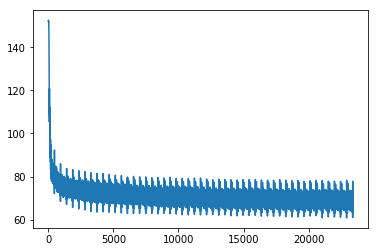

In [12]:
iterations_per_epoch = len(X_train) // BATCH_SIZE
losses = []

sess = tf.Session()

sess.run(tf.global_variables_initializer())

for e in range(EPOCHS):
    for i in range(iterations_per_epoch):
        batch = X_train[i*BATCH_SIZE : (i+1) * BATCH_SIZE]
        batch = np.expand_dims(batch, 3)
        l, _ = sess.run([loss, train], feed_dict={ img_input : batch })
        losses.append(l)
    
    if (e+1) % 10 == 0:
        print('Finished training epoch', e+1, 'with mean loss', np.mean(losses[-iterations_per_epoch:]))


plt.plot(losses)

## Visualization of the test set in the latent space

In [16]:
encodings = []
classes = []
for i in range(len(X_test)):
    img = X_test[i]
    img_in = [np.expand_dims(img, 3)]
    encoding = sess.run(z, feed_dict={ img_input : img_in })
    encodings.append(encoding[0])
    classes.append(y_test[i])
encodings = np.array(encodings)

/media/luca/a87b7b03-b48e-49f3-903a-66c8d0de2388/python_projects/virt_envs/tf_venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


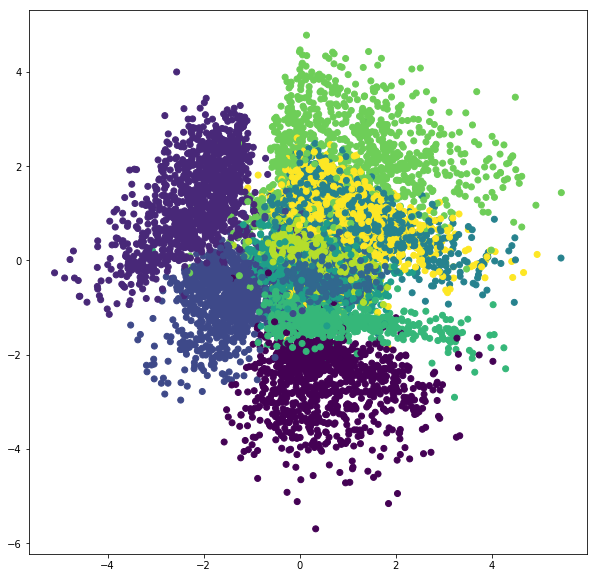

In [17]:
plt.figure(figsize=(10, 10))
plt.scatter(encodings[:, 0], encodings[:, 1], c=classes)

## Matrix of different decoded latent vectors

The vectors are generated according to position in the matrix.

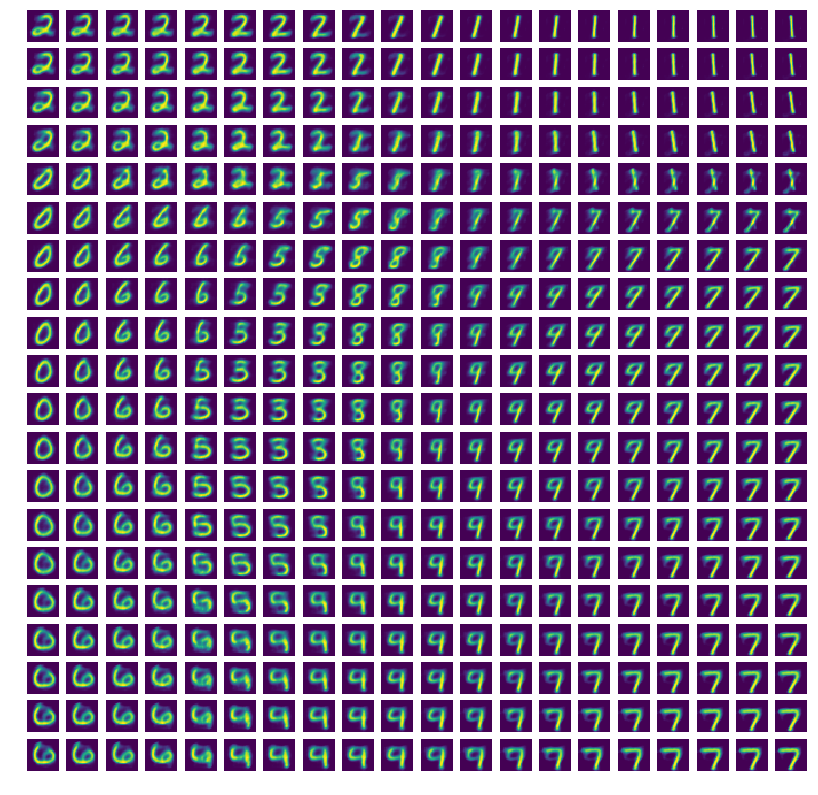

In [22]:
matrix_width, matrix_height = 20, 20
plt.figure(figsize=(14, 14))

for i in range(matrix_width * matrix_height):
    row, col = i // matrix_height, i % matrix_width
    sample_z = [row * 0.27 - 2, col * 0.27 - 2]
    construction = sess.run(decoding, feed_dict={ z_input : [sample_z] })
    plt.subplot(matrix_height, matrix_width, (i+1))
    plt.imshow(construction.reshape([28, 28]))
    plt.axis('off')